# Car price prediction

This project was created as a challange. To learn, prove my machine learning knowlage and ability to solve problems. It gave me aportunity to work on real live data and compare the score with others, since it was a Kaggle competition (closed but you can still post predictions and check your score.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.base import clone
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
%matplotlib inline

from collections import Counter

import eli5
from eli5.sklearn import PermutationImportance

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

Using TensorFlow backend.


Importing data:

Each entry in this database is a car with 155 features including car_price -> target variable

There are two subsets of data: train and test (test set is missing target variable), but for now they will be merged together.

In [2]:
train = pd.read_hdf('../car.h5')
test = pd.read_hdf('../test.car_price.h5')
print(train.shape)
print(test.shape)
train.sample()

(106494, 155)
(54122, 153)


,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,...,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id
152128,"[Osobowe, Volkswagen, Polo, Volkswagen Polo IV...","08:47, 23 lutego 2018",PLN,Cena Brutto,2950.0,"P - 62-650 Kłodawa, kolski, Wielkopolskie (Pol...",TOMAUTO,Dealer,False,False,...,None,Używane,IV (2001-2009),None,None,None,None,None,None,152128


In [4]:
df = pd.concat([train, test], sort=False)
del train, test
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160616 entries, 0 to 160613
Columns: 155 entries, breadcrumb to car_id
dtypes: bool(70), float64(1), int64(1), object(83)
memory usage: 116.1+ MB


Dataframe is to large for all information to show with default settings, so the settings were changed

In [15]:
pd.set_option('display.max_columns', 250)
pd.set_option('display.max_rows', 250)
df.head(3)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,feature_kurtyny-powietrzne,feature_klimatyzacja-dwustrefowa,feature_światła-led,feature_czujnik-zmierzchu,feature_elektrycznie-ustawiane-lusterka,feature_asr-(kontrola-trakcji),feature_poduszka-powietrzna-kierowcy,feature_cd,feature_elektryczne-szyby-przednie,feature_poduszka-powietrzna-pasażera,feature_system-start-stop,feature_światła-do-jazdy-dziennej,feature_komputer-pokładowy,feature_elektryczne-szyby-tylne,feature_klimatyzacja-manualna,feature_tapicerka-welurowa,feature_czujnik-deszczu,feature_światła-przeciwmgielne,feature_ogrzewanie-postojowe,feature_radio-niefabryczne,feature_regulowane-zawieszenie,feature_ogranicznik-prędkości,feature_zmieniarka-cd,feature_szyberdach,feature_isofix,feature_asystent-pasa-ruchu,feature_alufelgi,feature_bluetooth,feature_nawigacja-gps,feature_asystent-parkowania,feature_wspomaganie-kierownicy,feature_podgrzewana-przednia-szyba,feature_przyciemniane-szyby,feature_elektrycznie-ustawiane-fotele,feature_klimatyzacja-czterostrefowa,feature_tuner-tv,feature_poduszki-boczne-przednie,feature_tempomat-aktywny,feature_klimatyzacja-automatyczna,feature_poduszki-boczne-tylne,feature_radio-fabryczne,feature_odtwarzacz-dvd,feature_czujniki-parkowania-tylne,feature_łopatki-zmiany-biegów,feature_centralny-zamek,feature_dach-panoramiczny,feature_kamera-cofania,feature_immobilizer,feature_czujnik-martwego-pola,feature_gniazdo-sd,feature_podgrzewane-lusterka-boczne,feature_podgrzewane-przednie-siedzenia,feature_hak,feature_abs,feature_wielofunkcyjna-kierownica,feature_światła-xenonowe,feature_gniazdo-usb,feature_tapicerka-skórzana,feature_gniazdo-aux,feature_esp-(stabilizacja-toru-jazdy),feature_alarm,feature_podgrzewane-tylne-siedzenia,feature_mp3,feature_tempomat,feature_hud-(wyświetlacz-przezierny),feature_elektrochromatyczne-lusterko-wsteczne,feature_relingi-dachowe,feature_elektrochromatyczne-lusterka-boczne,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN,price_value_PLN_log
0,"[Osobowe, Dacia, Logan, Dacia Logan II (2012-)]","13:23, 5 marca 2018",PLN,Cena Brutto,45100.0,"Krasne 7A - 36-007 Krasne, rzeszowski, Podkarp...",AUTO SPEKTRUM,Dealer,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,Fals

In [16]:
df.dtypes

breadcrumb                                        object
created_at                                        object
price_currency                                    object
price_details                                     object
price_value                                      float64
seller_address                                    object
seller_name                                       object
seller_type                                       object
feature_czujniki-parkowania-przednie                bool
feature_poduszka-powietrzna-chroniąca-kolana        bool
feature_kurtyny-powietrzne                          bool
feature_klimatyzacja-dwustrefowa                    bool
feature_światła-led                                 bool
feature_czujnik-zmierzchu                           bool
feature_elektrycznie-ustawiane-lusterka             bool
feature_asr-(kontrola-trakcji)                      bool
feature_poduszka-powietrzna-kierowcy                bool
feature_cd                     

After preliminary data analysis there are few main issues to deal with:
- Target variable (car price) is in two currencies
- Some features are stored in two columns at the same time for example: 'param_liczba-drzwi' and 'param_door-count'
- Numerical data is stored as text

So starting with target variable it was normalized into one currency. For now fixed exchange rate was used equal 4.5. In effect a new target variable was created 'price_value_PLN'

In [6]:
df['price_currency'].value_counts()

PLN    160288
EUR       328
Name: price_currency, dtype: int64

In [7]:
def normalize_price_value(x):
    if x['price_currency'] == 'PLN':
        return x['price_value']
    elif x['price_currency'] == 'EUR':
        return x['price_value'] * 4.5
    
df['price_value_PLN'] = df[['price_currency', 'price_value']].apply(normalize_price_value, axis=1)

In [9]:
df.sample(5)

,breadcrumb,created_at,price_currency,price_details,price_value,seller_address,seller_name,seller_type,feature_czujniki-parkowania-przednie,feature_poduszka-powietrzna-chroniąca-kolana,...,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value,car_id,price_value_PLN
75028,"[Osobowe, Citroën, C5, Citroën C5 II (2004-2008)]","01:36, 4 marca 2018",PLN,"Cena Brutto, Do negocjacji",13400.0,"Góra Kalwaria, piaseczyński, Mazowieckie",None,Osoba prywatna,True,True,...,Używane,II (2004-2008),None,None,None,Tak,None,None,75028,13400.0
131076,"[Osobowe, Toyota, Auris, Toyota Auris I (2006-...","20:42, 2 marca 2018",PLN,"Cena Brutto, Do negocjacji",28900.0,"Dębowa 2 - 83-047 Jodłowno, gdański, Pomorskie...",Auto Lider Mirosław Sychta. Bezwypadkowe i zad...,Dealer,False,True,...,Używane,I (2006-2012),None,None,None,Tak,None,None,131076,28900.0
79673,"[Osobowe, Suzuki, Swift, Suzuki Swift V (2010-...","14:04, 1 marca 2018",PLN,NaN,NaN,"Suchedniów, skarżyski, Świętokrzyskie",None,Osoba prywatna,False,False,...,Używane,V (2010-2017),None,None,None,None,None,None,79673,NaN
48895,"[Osobowe, BMW, Seria 1, 120, BMW Seria 1 E87 (...","11:54, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji",18900.0,"Okulickiego 24 - 33-300 Nowy Sącz, Małopolskie...",CAR-TRONIC,Dealer,False,False,...,Używane,E87 (2004-2013),None,None,None,Tak,None,None,48895,18900.0
121422,"[Osobowe, Fiat, Bravo, Fiat Bravo II (2007-2014)]","09:55, 5 marca 2018",PLN,"Cena Brutto, Do negocjacji",19900.0,"BILCZA UL KIELECKA 14 - 26-026 Bilcza, kiele...","AUTO ,, BUGAJSKI """,Dealer,False,False,...,Używane,II (2007-2014),None,None,None,Tak,None,None,121422,19900.0


Target variable has a 'long tale' distribution so alternative logarithmic target variable 'price_value_PLN_log' was created, which in theory can be easier to predict. Later both target variables will be used to check which one is easier to predict.

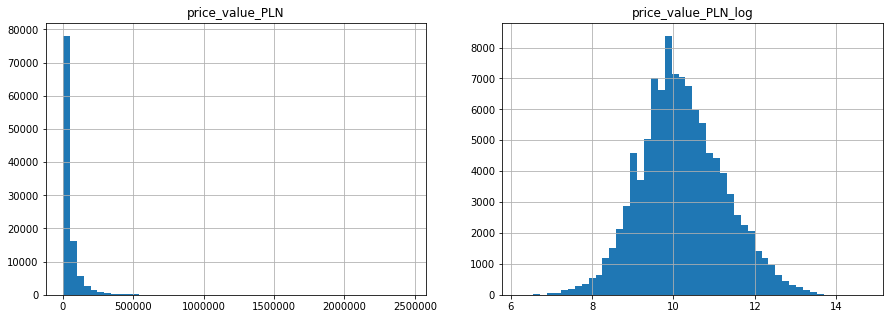

In [12]:
df['price_value_PLN_log'] = np.log1p(df['price_value_PLN'])

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
df['price_value_PLN'].hist(bins=50);
plt.title('price_value_PLN');
plt.subplot(1,2,2)
df['price_value_PLN_log'].hist(bins=50);
plt.title('price_value_PLN_log');

For now to speed up first model development all missing data was replaced with -1. Later in error analysis it will be decided if that simple solution is good enough.

In [13]:
print(df.isnull().sum().sum())
df = df.fillna(-1)
df.isnull().sum().sum()

9013997


0

For reference a dummy model was created.

In [18]:
model = DummyRegressor()
X = df[ 'seller_address' ]
y = df['price_value_PLN']
model.fit(X, y)
y_pred = model.predict(X)
mean_absolute_error(y_pred, y)

33565.50506397786

# feature engineering 

Standard cross_val_score function does not work with logaritmic target variables, so cross validating function below was created.

In [101]:
def get_X_y_and_cros_val(model, feats, log=False): # cross validation with option to use logarithmic target variable
    train_df = df[ df['price_value_PLN'] != -1]
    X = train_df[ feats ].values
    y = train_df['price_value_PLN'].values if not log else train_df['price_value_PLN_log'].values
    
    cv = KFold(n_splits=3, random_state=0, shuffle=True)
    scores = []
    for train_idx, test_idx in cv.split(y):
        
        train_model = clone(model)
        train_model.fit(X[train_idx], y[train_idx])
        
        y_pred = train_model.predict(X[test_idx])
        y_pred = np.expm1(y_pred) if log else y_pred
        
        score = mean_absolute_error(y[test_idx], y_pred)
        scores.append(score)
    return scores, np.std(scores)

For now all sets of features will be tested on the same model. To allow fast iterations with little down time while the model trains it will be a DecisionTreeRegressor with max_depth=5

In [49]:
model = DecisionTreeRegressor(max_depth=5, random_state=0)

Firs model was trained only on boolean features since these are good to go.

In [50]:
bool_feats = df.select_dtypes([np.bool]).columns
feats = bool_feats

get_X_y_and_cros_val(model, feats, log=False)

([25076.606847115643, 24909.340696410825, 24992.17567774242],
 68.28715648360107)

In [51]:
get_X_y_and_cros_val(model, feats, log=True)

([37271.07676178811, 37203.219877094125, 37630.83489943696],
 187.64182243430503)

For now model with the logarithmic target variable scored worse, will be double-checked later.

In [25]:
df.select_dtypes([np.object]).sample(3)

,breadcrumb,created_at,price_currency,price_details,seller_address,seller_name,seller_type,param_liczba-miejsc,param_uszkodzony,param_marka-pojazdu,param_model,param_engine-code,param_liczba-drzwi,param_first-registration,param_country-of-origin,param_pierwsza-rejestracja,param_gearbox,param_przebieg,param_faktura-vat,param_rok-produkcji,param_vin,param_perłowy,param_homologacja-ciężarowa,param_service-record,param_metallic,param_leasing-concession,param_color,param_financing-option,param_original-owner,param_vat-marża,param_kategoria,param_co2-emissions,param_leasing,param_mileage,param_zarejestrowany-jako-zabytek,param_napęd,param_wartość-wykupu,param_typ,param_metalik,param_pierwszy-właściciel,param_skrzynia-biegów,param_vat-discount,param_no-accident,param_liczba-pozostałych-rat,param_particle-filter,param_zarejestrowany-w-polsce,param_oferta-od,param_moc,param_make,param_kraj-pochodzenia,param_engine-power,param_year,param_serwisowany-w-aso,param_rodzaj-paliwa,param_możliwość-finansowania,param_registered-in-poland,param_transmission,param_miesięczna-rata,param_kod-silnika,param_version,param_opłata-początkowa,param_model-pojazdu,param_pojemność-skokowa,param_kierownica-po-prawej-(anglik),param_fuel-type,param_vat-free,param_acrylic,param_damaged,param_door-count,param_tuning,param_filtr-cząstek-stałych,param_nr-of-seats,param_kolor,param_engine-capacity,param_pearl,param_stan,param_wersja,param_emisja-co2,param_body-type,param_matowy,param_bezwypadkowy,param_akryl-(niemetalizowany),param_monthly-payment-value
40703,"[Osobowe, BMW, Seria 3, 320, BMW Seria 3 E46 (...","13:40, 2 marca 2018",PLN,-1,"Warszawa, Mazowieckie, Wawer",-1,Osoba prywatna,-1,-1,BMW,-1,-1,-1,-1,-1,-1,-1,243 500 km,-1,2001,Wbaap71050jl37794,-1,-1,-1,-1,-1,-1,-1,-1,-1,Osobowe,-1,-1,-1,-1,Na tylne koła,-1,Kombi,-1,-1,Manualna,-1,-1,-1,-1,Tak,Osoby prywatnej,150 KM,-1,Niemcy,-1,-1,-1,Diesel,-1,-1,-1,-1,320,-1,-1,Seria 3,2 000 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Używane,E46 (1998-2007),-1,-1,-1,-1,-1,-1
105184,"[Osobowe, Ford, Mondeo, Ford Mondeo Mk4 (2007-...","19:03, 3 marca 2018",PLN,Cena Brutto,"Raciborska 125 - 44-270 Rybnik, Śląskie (Polska)",Z Pierwszej Ręki,Dealer,-1,-1,Ford,-1,-1,-1,-1,-1,-1,-1,78 000 km,-1,2014,WF0EXXGBBEEJ48883,Tak,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,-1,-1,-1,Na przednie koła,-1,Sedan,Tak,Tak,Automatyczna hydrauliczna (klasyczna),-1,-1,-1,-1,Tak,Firmy,140 KM,-1,Polska,-1,-1,Tak,Diesel,-1,-1,-1,-1,-1,-1,-1,Mondeo,2 000 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Szary,-1,-1,Używane,Mk4 (2007-2014),-1,-1,-1,Tak,-1,-1
17087,"[Osobowe, Volkswagen, Passat, Volkswagen Passa...","15:19, 3 marca 2018",PLN,"Cena Brutto, Do negocjacji","Szczecińska 57 - 76-200 Słupsk, Pomorskie (Pol...",M&R CAR Auto Komis,Dealer,5,-1,Volkswagen,-1,-1,5,-1,-1,-1,-1,197 565 km,-1,2009,-1,-1,-1,-1,-1,-1,-1,-1,-1,Tak,Osobowe,-1,Tak,-1,-1,Na przednie koła,-1,Kombi,Tak,-1,"Automatyczna dwusprzęgłowa (DCT, DSG)",-1,-1,-1,-1,Tak,Firmy,-1,-1,-1,-1,-1,-1,Diesel,Tak,-1,-1,-1,-1,-1,-1,Passat,2 000 cm3,-1,-1,-1,-1,-1,-1,-1,-1,-1,Niebieski,-1,-1,Używane,B6 (2005-2010),-1,-1,-1,Tak,-1,-1


During many iterations of feature engineering least below were created.

In [26]:
# features worth merging (chosen after feature importance check)
doubles = {'param_liczba-drzwi': 'param_door-count',
          'param_przebieg': 'param_mileage',
           'param_pojemność-skokowa': 'param_engine-capacity',
           'param_emisja-co2': 'param_co2-emissions',
           'param_rok-produkcji': 'param_year',
           'param_rodzaj-paliwa': 'param_fuel-type',
           'param_moc': 'param_engine-power',
           'param_marka-pojazdu': 'param_make',
           'param_napęd': 'param_transmission',
           'param_skrzynia-biegów': 'param_gearbox',
           'param_kraj-pochodzenia': 'param_country-of-origin',
           'param_kolor': 'param_color'
          }

# numerical features
num_feats = ['param_liczba-miejsc', 'param_liczba-drzwi', 'param_przebieg', 'param_moc', 'param_pojemność-skokowa', 'param_emisja-co2', 'param_wartość-wykupu', 'param_liczba-pozostałych-rat', 'param_miesięczna-rata', 'param_opłata-początkowa']

# date features
date_feats = ['param_rok-produkcji', 'created_at', 'param_pierwsza-rejestracja', 'param_first-registration']

# blacklist features will not be used
black_list = ['breadcrumb', 'created_at', 'price_details', 'price_currency', 'price_value', 'price_value_PLN', 'price_value_PLN_log']

###### Mearging columns
As mentioned before some features are divided into two columns.

In [27]:
# Function used to find columns carrying the same information
val_to_check = 'Manualna'
for column in df.columns:
    occurrences = (df[column] == val_to_check).sum()
    if occurrences > 0:
        print('occurrences of '{}' in {}: {}'.format(val_to_check, column, occurrences))

/home/jupyter/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


occurrences of Manualna in param_gearbox: 91
occurrences of Manualna in param_skrzynia-biegów: 110590


To make sure no data is lost in the process each pairs of columns were checked if one column has missing data from other or if both have data for the same record.

In [29]:
def check_if_complementing(feat1, feat2):
    has_data = {feat1: 0 , feat2: 0, 'both': 0}
    for i in range(df.shape[0]):
        if df[feat1].iloc[i] != -1 and df[feat2].iloc[i] != -1:
            has_data['both'] += 1         
        elif df[feat1].iloc[i] != -1:
            has_data[feat1] += 1  
        elif df[feat2].iloc[i] != -1:
            has_data[feat2] += 1  
    print(has_data)
    
for feat1, feat2 in doubles.items():
    check_if_complementing(feat1, feat2)
    print()

{'param_liczba-drzwi': 145688, 'param_door-count': 117, 'both': 0}

{'param_przebieg': 159945, 'param_mileage': 127, 'both': 0}

{'param_pojemność-skokowa': 152840, 'param_engine-capacity': 122, 'both': 0}

{'param_emisja-co2': 3114, 'param_co2-emissions': 3, 'both': 0}

{'param_rok-produkcji': 160327, 'param_year': 128, 'both': 0}

{'param_rodzaj-paliwa': 160327, 'param_fuel-type': 128, 'both': 0}

{'param_moc': 146331, 'param_engine-power': 115, 'both': 0}

{'param_marka-pojazdu': 160327, 'param_make': 128, 'both': 0}

{'param_napęd': 135893, 'param_transmission': 110, 'both': 0}

{'param_skrzynia-biegów': 151750, 'param_gearbox': 121, 'both': 0}

{'param_kraj-pochodzenia': 109150, 'param_country-of-origin': 82, 'both': 0}

{'param_kolor': 160327, 'param_color': 128, 'both': 0}



After confirming that no data will be lost the columns were merged.

In [31]:
def merge_data(x):
    if x.iloc[0] == -1 and x.iloc[1] != -1:
        return x.iloc[1]
    else:
        return x.iloc[0]
    
# merge data
for feat1, feat2 in doubles.items():
    df[feat1] = df[[feat1, feat2]].apply(merge_data, axis=1)
    
# delete no longer needed columns
to_delate = doubles.values()
for d in to_delate:
    del df[d]

###### Caterogical features

Categorical features were selected and changed into numerical values using factorize. 

In [32]:
cat_black_list = black_list + num_feats + date_feats

cat_feats = df.select_dtypes([np.object]).columns
cat_feats = [x for x in cat_feats if x not in cat_black_list]

# using factorize on categorical features
cat_feat_prefix = '__cat'
for cat in cat_feats:
    df[cat + cat_feat_prefix] = pd.factorize( df[cat] )[0]
    
# storing factorized features in 'cat_feats'
cat_feats = df.columns
cat_feats = [x for x in cat_feats if cat_feat_prefix in x]
cat_feats

['seller_address__cat',
 'seller_name__cat',
 'seller_type__cat',
 'param_uszkodzony__cat',
 'param_marka-pojazdu__cat',
 'param_model__cat',
 'param_engine-code__cat',
 'param_faktura-vat__cat',
 'param_vin__cat',
 'param_perłowy__cat',
 'param_homologacja-ciężarowa__cat',
 'param_service-record__cat',
 'param_metallic__cat',
 'param_leasing-concession__cat',
 'param_financing-option__cat',
 'param_original-owner__cat',
 'param_vat-marża__cat',
 'param_kategoria__cat',
 'param_leasing__cat',
 'param_zarejestrowany-jako-zabytek__cat',
 'param_napęd__cat',
 'param_typ__cat',
 'param_metalik__cat',
 'param_pierwszy-właściciel__cat',
 'param_skrzynia-biegów__cat',
 'param_vat-discount__cat',
 'param_no-accident__cat',
 'param_particle-filter__cat',
 'param_zarejestrowany-w-polsce__cat',
 'param_oferta-od__cat',
 'param_kraj-pochodzenia__cat',
 'param_serwisowany-w-aso__cat',
 'param_rodzaj-paliwa__cat',
 'param_możliwość-finansowania__cat',
 'param_registered-in-poland__cat',
 'param_kod-

To check the progress made a model was trained using boolean and cat features. Score improved by more than 5k.

In [33]:
feats = list(bool_feats) + list(cat_feats)
get_X_y_and_cros_val(model, feats)

([20197.073105073003, 20364.769520262143, 20305.01155346451],
 69.39725491228151)

All relevant categorical features were ploted for further analizys (charts are sorted by value_counts)

In [34]:
# plotting categorical features to look for potentially important ones
# categories are sorted by value_counts


cat_no_plot = ['price_currency__cat', 'seller_address__cat', 'seller_name__cat', 'param_engine-code__cat','param_vin__cat', 'param_kod-silnika__cat', 'param_wersja__cat', 'param_model-pojazdu__cat']

# for cat_feat in cat_feats:
#     if cat_feat not in cat_no_plot:
#         cat_name = cat_feat[:-len(cat_feat_prefix)]
#         plt.figure(figsize=(20,5))
#         sns.barplot(x=cat_name, y='price_value_PLN', data=df, order=df[cat_name].value_counts().index, color='#3498db');
#         plt.xticks(rotation=90);
#         plt.show()

###### numerical features

Numerical features had to be picked manually because they were originally stored as an object. They were stripped of units and spaces, so they can be stored and analized properly from now on.

In [38]:
num_feats

['param_liczba-miejsc',
 'param_liczba-drzwi',
 'param_przebieg',
 'param_moc',
 'param_pojemność-skokowa',
 'param_emisja-co2',
 'param_wartość-wykupu',
 'param_liczba-pozostałych-rat',
 'param_miesięczna-rata',
 'param_opłata-początkowa']

In [39]:
df['param_moc'].sample(5)

145295    125 KM
25267      75 KM
82403     110 KM
17914         -1
115681    231 KM
Name: param_moc, dtype: object

In [40]:
def get_rid_of_unit_and_dec(val): # getting rid of units, spaces between numbers and decimals
    if val == -1:
        return -1

    st = ''.join(val.split(' ')[:-1])
    
    if ',' in st:
        st = ''.join(st.split(',')[:-1])

    val = int(st)
        
    return val


num_feat_prefix = '__num'
df['param_liczba-miejsc' + num_feat_prefix] = df['param_liczba-miejsc'].astype(np.int8)
df['param_liczba-drzwi' + num_feat_prefix] = df['param_liczba-drzwi'].astype(np.int8)

df['param_przebieg' + num_feat_prefix] = df['param_przebieg'].map(get_rid_of_unit_and_dec)
df['param_moc' + num_feat_prefix] = df['param_moc'].map(get_rid_of_unit_and_dec)
df['param_pojemność-skokowa' + num_feat_prefix] = df['param_pojemność-skokowa'].map(get_rid_of_unit_and_dec)
df['param_emisja-co2' + num_feat_prefix] = df['param_emisja-co2'].map(get_rid_of_unit_and_dec)
df['param_wartość-wykupu' + num_feat_prefix] = df['param_wartość-wykupu'].map(get_rid_of_unit_and_dec)
df['param_miesięczna-rata' + num_feat_prefix] = df['param_miesięczna-rata'].map(get_rid_of_unit_and_dec)
df['param_opłata-początkowa' + num_feat_prefix] = df['param_opłata-początkowa'].map(get_rid_of_unit_and_dec)

# df['param_liczba-pozostałych-rat' + num_feat_prefix] = df['param_liczba-pozostałych-rat'].map(lambda x: int(''.join(x.split(' '))) if x != -1 else -1 )

df['param_rok-produkcji' + num_feat_prefix] = df['param_rok-produkcji'].astype(np.int16)

num_feats = [x for x in df.columns if num_feat_prefix in x]

To check progress made a model was trained using all prepared features. Score significantly improved.

In [52]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)

get_X_y_and_cros_val(model, feats, log=False)

([14198.374124514623, 14763.794219479261, 14567.378956949546],
 234.38889941120485)

Double checking with logarithmic target variable.

In [43]:
get_X_y_and_cros_val(model, feats, log=True)

([43533.61941461478, 44240.73875922517, 43841.12826924862], 289.4953476693411)

###### feature importance check

After each iteration of feature engineering feature importance and permutation importance was checked to look for features worth working on in the next step.

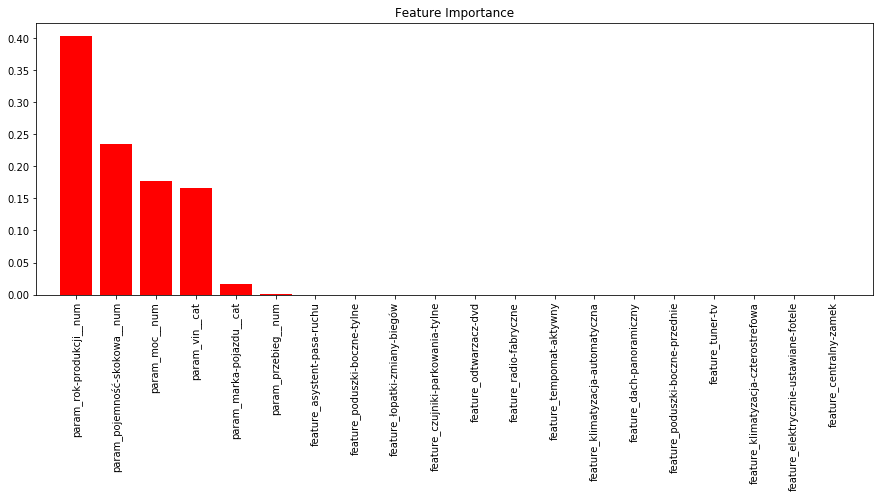

In [59]:
X = df[ feats ]
y = df['price_value_PLN']
model.fit(X, y)
skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))

To double check also Permutation Importance was check since it is calculated diferently.

In [60]:
imp = PermutationImportance(model, random_state=0).fit(X,y)
eli5.show_weights(imp, feature_names=feats)

Weight,Feature
0.5335 ± 0.0079,param_rok-produkcji__num
0.1899 ± 0.0026,param_moc__num
0.1865 ± 0.0132,param_pojemność-skokowa__num
0.1577 ± 0.0056,param_vin__cat
0.0095 ± 0.0011,param_marka-pojazdu__cat
0.0018 ± 0.0002,param_przebieg__num
0 ± 0.0000,feature_łopatki-zmiany-biegów
0 ± 0.0000,feature_czujniki-parkowania-tylne
0 ± 0.0000,feature_odtwarzacz-dvd
0 ± 0.0000,feature_immobilizer


During error analysis in the end it came out that biggest error is generated by luxury car brands so an additional boolean feature 'luxury_car' was created.

In [74]:
luxury_car_brands = ['McLaren', 'Ferrari', 'Aston Martin', 'Lamborghini', 'Bentley', 'Rolls-Royce', 'Morgan']
df['luxury_car'] = df['param_marka-pojazdu'].map(lambda x: True if x in luxury_car_brands else False)
bool_feats = list(bool_feats)
if 'luxury_car' not in bool_feats: bool_feats.append('luxury_car')

# Preparing test train set

After feature engineering sets were divided back into train and tes.

In [78]:
df[ df['price_value_PLN'] == -1 ].shape

NameError: name 'df' is not defined

In [79]:
train = df[ df['price_value_PLN'] != -1]
test = df[ df['price_value_PLN'] == -1 ]

del df

NameError: name 'df' is not defined

In [80]:
print(train.shape)
print(test.shape)

(106494, 210)
(54122, 210)


# Model selection and optimization

Using logarithm of target variable did not bring results. All models will be tested on the same set of features using standard 3 fold cross_val_score function.

In [81]:
feats = list(bool_feats) + list(cat_feats) + list(num_feats)


def get_X_y(feats):
    return train[ feats ].values, train['price_value_PLN'].values

def test_model(model, feats):
    X, y = get_X_y(feats)
    
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    return np.abs(np.mean(scores)), np.std(scores)

def plot_fi_lc_e5(model, feats, pi=True, lc=True, e5=False):
    X, y = get_X_y(feats)
    model.fit(X, y)
    
    if pi:
        skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(15, 5))
    if lc:
        skplt.estimators.plot_learning_curve(model, X, y, figsize=(15, 5), cv=3, scoring='neg_mean_absolute_error');
    if e5:
        imp = PermutationImportance(model, random_state=0).fit(X,y)
        return eli5.show_weights(imp, feature_names=feats)

def get_model_importance(model, feats):
    X, y = get_X_y(feats)
    model.fit(X, y)
    importances = model.feature_importances_
    m_imp = [(feats[idx], importances[idx]) for idx in range(len(feats))]
    return sorted(m_imp, key=lambda x: x[1], reverse=True)

Firstly scores and feature importances were checked for few different models.

In [82]:
# Testing decision Tree
model = DecisionTreeRegressor(max_depth=10, random_state=0)
test_model(model, feats)

(10644.048265172052, 159.14087545985666)

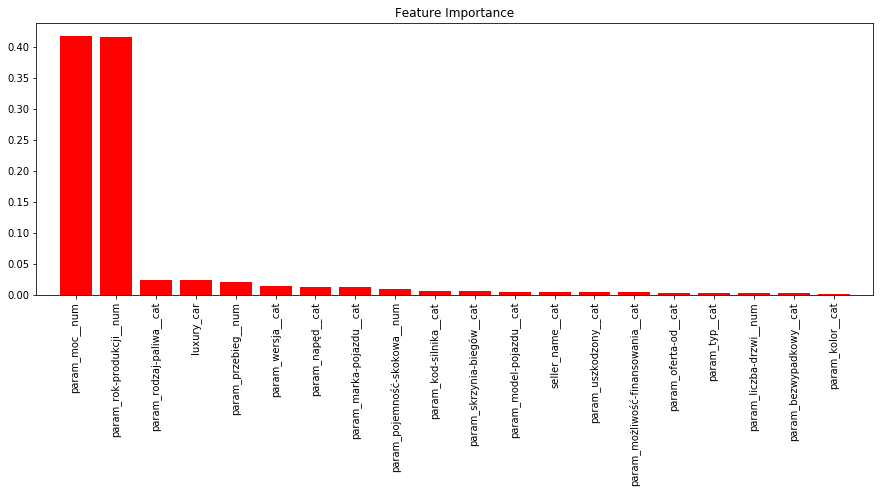

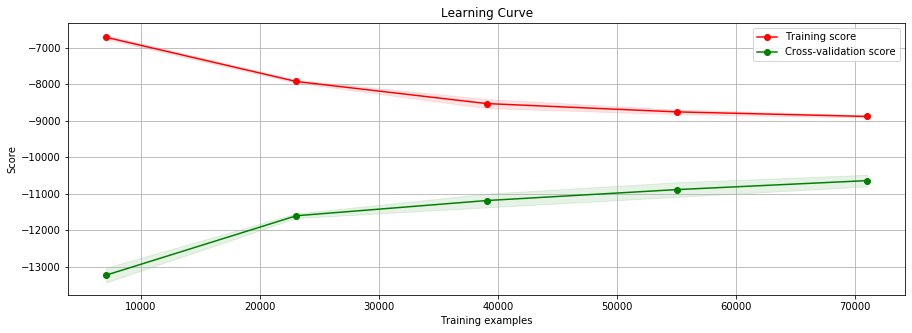

In [83]:
plot_fi_lc_e5(model, feats, True, True, False)

In [84]:
# Testing Random Forest
model = RandomForestRegressor(max_depth=10, n_estimators=50, random_state=0)
test_model(model, feats)

(9264.447409362983, 90.94774848651642)

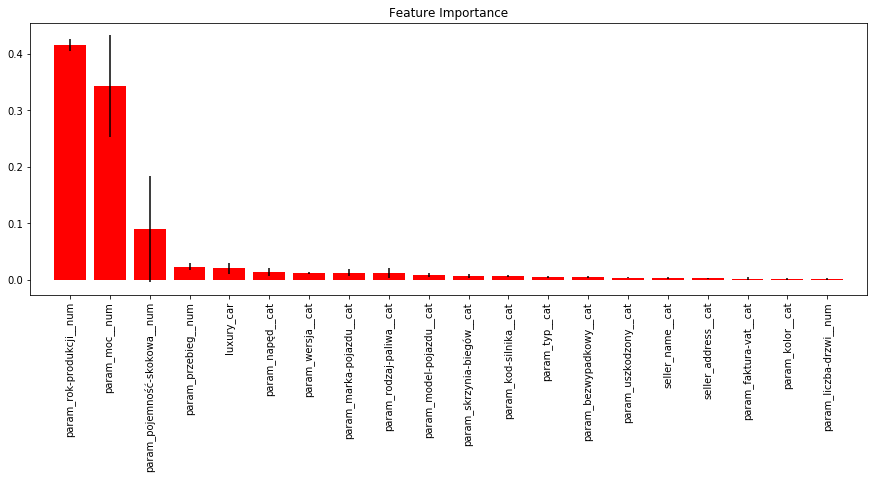

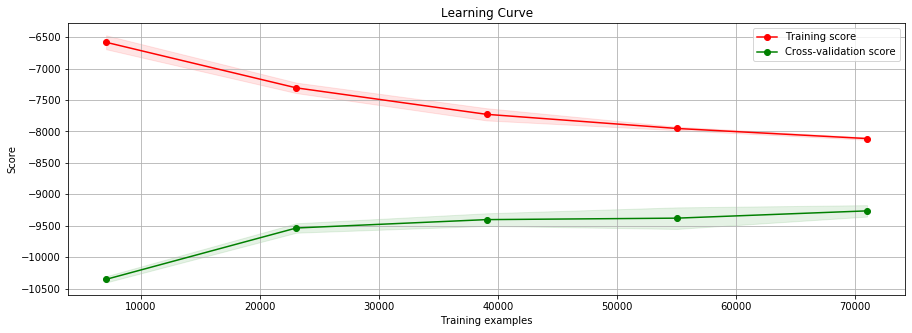

In [85]:
plot_fi_lc_e5(model, feats, True, True, False)

In [97]:
# testing XGB regressor
xgb_params = {
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'seed': 0
}

model = XGBRegressor(**xgb_params)
test_model(model, feats)

(7163.476648377429, 52.13927906121344)

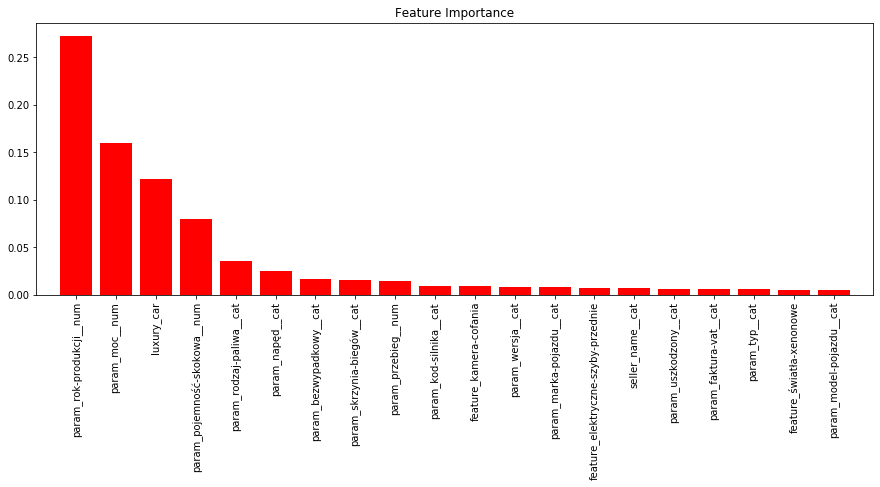

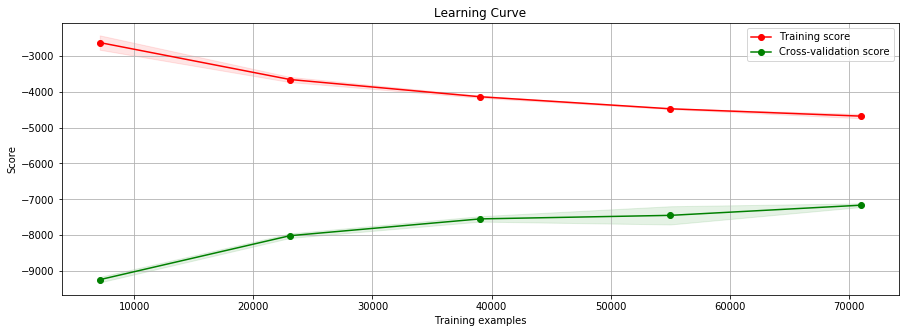

In [87]:
plot_fi_lc_e5(model, feats, True, True, False)

Error in Kagle is calculated using mae, since it can not be used as loss function in a model, a similar 'fair loss' function was used, to ensure that model optimizes in the right direction.

In [96]:
def fair_obj(y_true, y_pred):
    x = y_pred - y_true

    den = abs(x) + fair_constant
    
    grad = fair_constant * x / den
    hess = (fair_constant * fair_constant) / (den * den)
    
    return grad, hess

xgb_params = {
    'objective': fair_obj,
    'max_depth': 10,
    'n_estimators': 50,
    'learning_rate': 0.1,
    'seed': 0
}

fair_constant = 4950
model = XGBRegressor(**xgb_params)
test_model(model, feats)

(8412.859276492703, 234.60832012216483)

In [95]:
X = train[feats].values
y = train['price_value_PLN'].values

def objective(space):

    global fair_constant
    fair_constant = space['fair_constant']
    xgb_params = {
        'objective': fair_obj,
        'max_depth': 10,
        'n_estimators': 50,
        'learning_rate': 0.1,
        'seed': 0
    }
    print('Testing: {}'.format(fair_constant))

    model = XGBRegressor(**xgb_params)
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    score = np.abs(np.mean(scores))

#     print(scores)
    print('final_score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'fair_constant': hp.quniform ('fair_constant', 1, 5000, 1)
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=40,
            trials=trials)

print("The best params: ", best_params)

Testing: 3294.0                                       
final_score: 9736.284322529098                        

Testing: 3340.0                                                                
final_score: 9581.811789751078                                                 

Testing: 3249.0                                                                
final_score: 8856.073634717492                                                 

Testing: 432.0                                                                 
final_score: 18402.44537880676                                                 

Testing: 1114.0                                                                
final_score: 12710.343750368907                                                

Testing: 2522.0                                                                
final_score: 10209.905232361643                                                

Testing: 1594.0                                                                
fina

Additionally the hyperparameter of the XGB regressor were optimized using fmin function.

In [102]:
X = train[feats].values
y = train['price_value_PLN'].values

def fair_obj(y_true, y_pred):
    x = y_pred - y_true

    den = abs(x) + fair_constant
    
    grad = fair_constant * x / den
    hess = (fair_constant * fair_constant) / (den * den)
    
    return grad, hess

def objective(space):

    global fair_constant
    fair_constant = space['fair_constant']
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 100,
        'objective': fair_obj,
        'seed':0
    }

    model = XGBRegressor(**xgb_params)
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    score = np.abs(np.mean(scores))

#     print(scores)
    print('final_score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
    'fair_constant': hp.quniform ('fair_constant', 1, 5000, 1)
    
}

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=20),
            max_evals=200,
            trials=trials)

print("The best params: ", best_params)

final_score: 10771.181086490358                        

final_score: 8475.855732858252                                                     

final_score: 12462.1458231889                                                      

final_score: 12460.816053461742                                                   

final_score: 13502.260175754256                                                   

final_score: 41361.97257173152                                                    

final_score: 15883.28350084777                                                    

final_score: 32697.587191806848                                                   

final_score: 27189.963189001763                                                   

final_score: 24380.874116819567                                                   

final_score: 11405.77177153485                                                     

final_score: 11691.750026390677                                                    

final_score: 16

final_score: 7516.409372173242                                                       

final_score: 7975.959172768234                                                       

final_score: 8057.492723630687                                                       

final_score: 7424.532421245105                                                       

final_score: 7604.985817359583                                                       

final_score: 7246.987449152574                                                        

final_score: 16345.277746919639                                                       

final_score: 11294.598658878656                                                       

final_score: 9163.19321744686                                                         

final_score: 7277.191112530182                                                        

final_score: 7605.059920840002                                                        

final_score: 7658.756090635485       

final_score: 7358.162406397459                                                      

final_score: 7359.645201404613                                                      

final_score: 7223.498028997809                                                      

final_score: 11469.33838627486                                                      

final_score: 9111.722281030716                                                      

final_score: 7754.239870976125                                                      

final_score: 58338.073977260145                                                     

final_score: 22280.160490936807                                                     

final_score: 7872.325901956235                                                      

final_score: 26901.960367566197                                                     

final_score: 7281.931801406005                                                      

final_score: 7225.318147493581                        

In [ ]:
# Since XBG looks most promising it gets hyper optimized

X = df[feats].values
y = df['price_value_PLN'].values

def objective(space):

    xgb_params = {
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'colsample_bytree': space['colsample_bytree'],
        'subsample': space['subsample'],
        'min_child_weight': int(space['min_child_weight']),
        'n_estimators': 100,
        'objective': 'reg:squarederror',
        'seed':0
    }

    print('training wiht params: {}'.format(xgb_params))
    model = XGBRegressor(**xgb_params)
    scores = cross_val_score(model, X, y, cv=3, scoring="neg_mean_absolute_error")
    score = np.abs(np.mean(scores))

    print(scores)
    print('final_score: {}\n'.format(score))
    return{'loss':score, 'status': STATUS_OK }

space ={
    'max_depth': hp.quniform ('max_depth', 1, 20, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.8, 1.),
    'subsample': hp.uniform ('subsample', 0.7, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 0.3),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=10),
            max_evals=30,
            trials=trials)

print("The best params: ", best_params)

After hyperoptimization new hyperparameters were checked:

In [ ]:
xgb_params_opt = {'colsample_bytree': 0.8788921383871157,
                  'learning_rate': 0.10169026353664928,
                  'max_depth': 13,
                  'min_child_weight': 1,
                  'subsample': 0.8444300922311613,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params_opt)

In [ ]:
test_model(model, feats)

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

Model seems to be a bit over fitted so parameters were changed to:

In [ ]:
xgb_params = {'colsample_bytree': 0.8,
                  'learning_rate': 0.1,
                  'max_depth': 10,
                  'min_child_weight': 1,
                  'subsample': 0.8,
                  'n_estimators': 100, 
                  'objective': 'reg:squarederror', 
                  'seed':0
                 }

model = XGBRegressor(**xgb_params)
test_model(model, feats)

In [ ]:
plot_fi_lc_e5(model, feats, True, True, False)

Also model feature importance was checked to finally decide which features are relewant.

In [ ]:
get_model_importance(model, feats)

In [ ]:
less_feats = [ x[0] for x in get_model_importance(model, feats) if x[1] > 0.0040 ]
less_feats

In [ ]:
print(len(less_feats))
model = XGBRegressor(**xgb_params)
test_model(model, less_feats)

# Error analysis

During this project on various occasions model error was analysed. To do so error was calculated per record. 

In [ ]:
X, y = get_X_y(feats)

y_pred = cross_val_predict(model, X, y, cv=3)
train['pred'] = y_pred
train['error'] = train[['pred', 'price_value_PLN']].apply(lambda x: np.abs(x['pred'] - x['price_value_PLN']), axis=1)

To check where features can be improved records were grouped per feature. And displayed as a chart.

In [ ]:
train.groupby('param_marka-pojazdu').agg(count=('param_marka-pojazdu', np.size),mae=('error', np.mean)).reset_index().sort_values('mae', ascending=False).sort_values('mae', ascending=False)

In [ ]:
train[ train['param_marka-pojazdu'] == 'MacLaren' ].sort_values('error')

In [ ]:
cat_to_check = [x for x in cat_feats if len(train[x].unique()) > 4]
cat_to_check = [x for x in cat_to_check if x not in cat_no_plot]

max_cat_mae = 0
for cat in cat_to_check:
    cat_mae = train.groupby(cat).agg(mae=('error', np.mean))['mae'].max()
    if cat_mae > max_cat_mae:
        max_cat_mae = cat_mae

for cat_feat in cat_to_check:
    cat_name = cat_feat[:-len(cat_feat_prefix)]
    plt.figure(figsize=(20,5))
    order = train.groupby(cat_name)['error'].agg(np.mean).reset_index().sort_values('error', ascending=False)[cat_name]
    ax = sns.barplot(x=cat_name, y='error', data=train, order=train[cat_name].value_counts().index, color='#3498db');
    plt.xticks(rotation=90);
    ax.set(ylim=(0, max_cat_mae))
    plt.show()

As you can see even though the luxury car feature was added and is in top most important features the luxury car segment is still generating most error. You can also see that replacing missing error with -1 did not generate such big error that using more time consuming methods would be justified.

# Final predict and submit data preparation

In [ ]:
test.sample()

In [ ]:
model = XGBRegressor(**xgb_params)

model.fit(train[feats], train['price_value_PLN'])
test['price_value_PLN'] = model.predict(test[feats])
test['price_value'] = test[['price_value_PLN', 'price_currency']].apply(lambda x: x['price_value_PLN'] if x['price_currency'] == 'PLN' else x['price_value_PLN'] / 4.5, axis =1)

test[ ['car_id', 'price_value'] ].to_csv('../car_test_predict.csv', index=False)

# osiągnąć top 10%